In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly as pt
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [22]:
data = pd.read_excel(r'POCM_HISTORICAL.xlsx')
df1 = data[["Checkout_Date","Order_Quantity"]]

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160577 entries, 0 to 160576
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Checkout_Date   160577 non-null  datetime64[ns]
 1   Order_Quantity  160577 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 MB


In [24]:
df1

,Checkout_Date,Order_Quantity
0,2018-12-04,1
1,2018-12-04,1
2,2018-12-05,5
3,2018-12-05,10
4,2018-12-05,20
...,...,...
160572,2020-05-15,5
160573,2020-05-15,20
160574,2020-05-15,2
160575,2020-05-15,3


In [64]:
df = df1.groupby(["Checkout_Date"])['Order_Quantity'].sum().reset_index()
df.tail()

,Checkout_Date,Order_Quantity
465,2020-05-11,2749
466,2020-05-12,3366
467,2020-05-13,1491
468,2020-05-14,6631
469,2020-05-15,1018


In [26]:
#selecting a time specific data, we can consider it as our train data 
daily1 = df.loc[df['Checkout_Date'].between('2018-12-04','2020-04-30', inclusive=True)]

#we can consider it as test data after training and getting prediction of the previous data.
daily2 = df.loc[df['Checkout_Date'].between('2020-05-01','2020-05-15', inclusive=True)]

In [37]:
daily1.tail()

,ds,y
454,2020-04-26,2
455,2020-04-27,170
456,2020-04-28,78
457,2020-04-29,115
458,2020-04-30,750


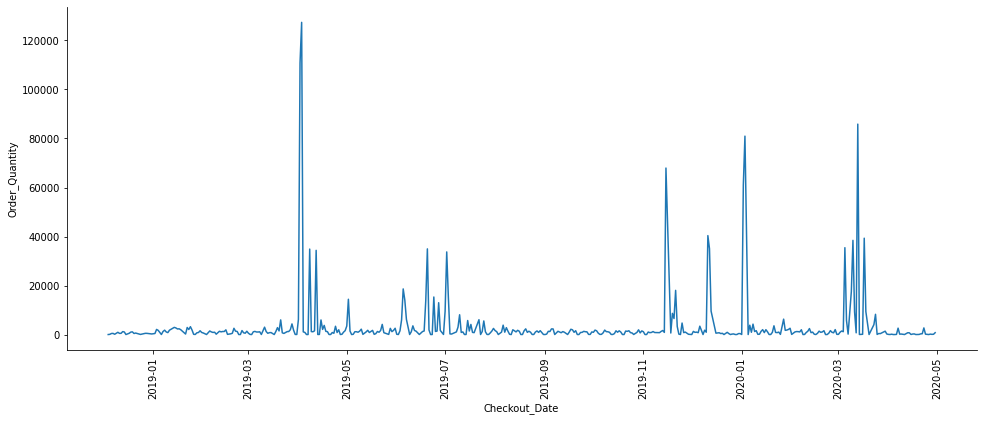

In [28]:
sns.relplot(x = 'Checkout_Date', y = 'Order_Quantity', data = daily1, kind = 'line', height = 5.5, aspect = 2.5)
plt.xticks(rotation='vertical')
plt.show()

In [29]:
model = Prophet()
daily1.columns = ['ds', 'y']

In [30]:
daily1.tail()

,ds,y
454,2020-04-26,2
455,2020-04-27,170
456,2020-04-28,78
457,2020-04-29,115
458,2020-04-30,750


In [31]:
model = model.fit(daily1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = model.make_future_dataframe(periods= 15)
future.tail()

,ds
469,2020-05-11
470,2020-05-12
471,2020-05-13
472,2020-05-14
473,2020-05-15


In [33]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
469,2020-05-11,3656.899539,-10716.160561,18244.981180,3656.870981,3656.931046,-583.424374,-583.424374,-583.424374,-583.424374,-583.424374,-583.424374,0.0,0.0,0.0,3073.475165
470,2020-05-12,3659.399482,-9669.415555,18828.306724,3659.364802,3659.435262,1648.870184,1648.870184,1648.870184,1648.870184,1648.870184,1648.870184,0.0,0.0,0.0,5308.269666
471,2020-05-13,3661.899425,-8867.285475,19572.495283,3661.853154,3661.942083,1471.131418,1471.131418,1471.131418,1471.131418,1471.131418,1471.131418,0.0,0.0,0.0,5133.030843
472,2020-05-14,3664.399367,-9657.396345,20864.139435,3664.346838,3664.449569,1388.198489,1388.198489,1388.198489,1388.198489,1388.198489,1388.198489,0.0,0.0,0.0,5052.597856
473,2020-05-15,3666.899310,-9453.904577,20583.584990,3666.837808,3666.954865,2039.183785,2039.183785,2039.183785,2039.183785,2039.183785,2039.183785,0.0,0.0,0.0,5706.083095


In [34]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [42]:
plot_components_plotly(model, forecast)

In [87]:
f1 = forecast.loc[forecast['ds'].between('2020-05-01','2020-05-15', inclusive=True)][['ds', 'yhat']]
f1 = f1.set_index('ds')
f1 = f1[(f1.index.dayofweek < 5)]
f1

,yhat
ds,
2020-05-01,5671.083898
2020-05-04,3055.975567
2020-05-05,5290.770068
2020-05-06,5115.531245
2020-05-07,5035.098258
2020-05-08,5688.583497
2020-05-11,3073.475165
2020-05-12,5308.269666
2020-05-13,5133.030843


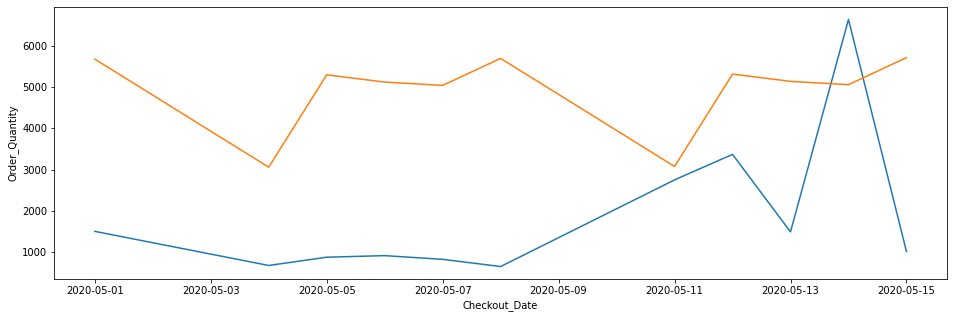

In [85]:
#Comparing the forecasted and original data plots

plt.figure(figsize=(16,5))
sns.lineplot(x= daily2['Checkout_Date'], y= daily2["Order_Quantity"])
sns.lineplot(x= f1.index, y = f1.yhat)

In [86]:
# Checking Evaluation/Performance Metrics

prophet_rmse_error = rmse(daily2['Order_Quantity'], f1["yhat"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Order_Quantity'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 13166503.243065955
RMSE Error: 3628.5676572259135
Mean: 3314.923404255319
